In [1]:
%matplotlib inline

/Users/shoji/go/src/github.com/mikanfactory/CanDataAnalyzer/venv/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.mixture import BayesianGaussianMixture
from skbayes.mixture_models import VBBMM

In [3]:
import seaborn as sns
sns.set(color_codes=True)

# Preprocess

In [24]:
targetDir = "../data/output/d3/Result/"
speedDir = "../data/output/d3/Speed/"
brakeDir = "../data/output/d3/Brake/"
accelDIr = "../data/output/d3/Accel/"
steeringPositiveDir = "../data/output/d3/SteeringPositive/"
steeringNegativeDir = "../data/output/d3/SteeringNegative/"
aheadDistance = "../data/output/d3/AheadDistance/"
relativitySpeed = "../data/output/d3/AheadRelativitySpeed/"
segmentDir = "../data/output/d3/SegmentSize/"

In [25]:
df1 = pd.read_csv(speedDir + "result.csv")
df2 = pd.read_csv(brakeDir + "result.csv")
df2.columns = [["id", "brake"]]
df3 = pd.read_csv(accelDIr + "result.csv")
df3.columns = [["id", "accel"]]
df4 = pd.read_csv(steeringPositiveDir + "result.csv")
df4.columns = [["id", "steeringPositive"]]
df5 = pd.read_csv(steeringNegativeDir + "result.csv")
df5.columns = [["id", "steeringNegative"]]
df6 = pd.read_csv(aheadDistance + "result.csv")
df6.columns = [["id", "near", "intermediate", "far"]]
df7 = pd.read_csv(relativitySpeed + "result.csv")
df7.columns = [["id", "moderate", "slower", "little faster", "faster"]]
df8 = pd.read_csv(segmentDir + "result.csv")
df8.columns = [["id", "segmentSize"]]

In [26]:
df = pd.merge(pd.merge(pd.merge(pd.merge(df1, df2, on="id"), df3, on="id"), df4, on="id"), df5, on="id")
df = pd.merge(pd.merge(df, df6, on="id"), df7, on="id")
df = pd.merge(df, df8, on="id")
gridSize = len(df)

In [35]:
mf = df[df['red'] + df['yellow'] + df['green'] + df['stop'] > 0]
mf = mf[["red", "yellow", "green", "stop", "brake", "accel", "steeringPositive",  "steeringNegative", "near", "intermediate", "far", "moderate", "slower", "little faster", "faster", "segmentSize"]]
mf.columns = ["red", "yellow", "green", "slow", "brake", "accel", "steeringPositive",  "steeringNegative", "near", "intermediate", "far", "moderate", "slower", "little faster", "faster", "segmentSize"]

# Summation of all statuses and calculate risk

In [36]:
rows = mf.as_matrix()
mf["sum"] = [np.sum(rows[i][:-1]) for i in range(len(rows))]

In [37]:
mf["risk"] = mf["sum"] / mf["segmentSize"]

In [38]:
mf.describe()

,red,yellow,green,slow,brake,accel,steeringPositive,steeringNegative,near,intermediate,far,moderate,slower,little faster,faster,segmentSize,sum,risk
count,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000
mean,2.721154,1.692308,0.567308,1.240385,2.028846,1.490385,0.884615,0.557692,1.048077,1.836538,1.298077,3.163462,0.105769,0.365385,0.557692,4.192308,19.557692,4.533680
std,3.281181,1.520583,1.121411,5.162402,3.454157,3.075096,2.815725,2.715747,4.569591,1.712947,1.694536,5.411442,0.438848,0.683476,0.953552,5.532037,27.874834,1.917484
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,3.000000,3.000000
25%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,2.000000,8.000000,3.000000
50%,2.000000,2.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,2.000000,1.000000,2.000000,0.000000,0.000000,0.000000,3.000000,11.000000,4.000000
75%,3.000000,3.000000,0.250000,0.000000,3.000000,2.000000,1.000000,0.000000,0.000000,3.000000,2.000000,3.000000,0.000000,1.000000,1.000000,4.000000,21.250000,5.333333
max,30.000000,5.000000,4.000000,36.000000,30.000000,28.000000,27.000000,27.000000,36.000000,8.000000,13.000000,39.000000,3.000000,4.000000,4.000000,41.000000,222.000000,13.000000


In [39]:
top5 = mf.sort_values("risk", ascending=False)[:5]
top5 = top5[["red", "brake", "accel", "steeringNegative", "steeringPositive", "sum"]]

for key in top5.columns:
    if key == "sum":
        continue
    top5[key] = top5[key] / top5["sum"]

top5 = top5[["red", "brake", "accel", "steeringNegative", "steeringPositive"]]
top5Index = top5.index

In [40]:
top5Index

Int64Index([55, 94, 213, 441, 682], dtype='int64')

# Save

In [41]:
pred = zip(mf.index, mf["risk"])
result = np.zeros(gridSize)

for index, risk in pred:
    result[index] = risk
    
np.savetxt(targetDir + "risks.csv", result, delimiter=",", fmt="%f")

# Risk graph order by index

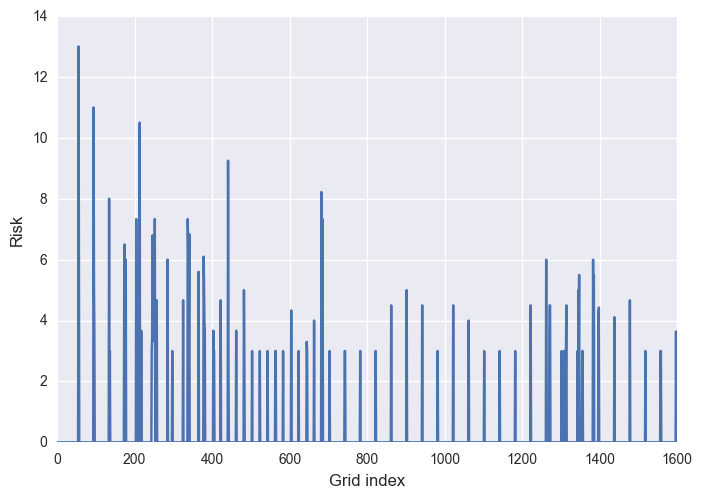

In [44]:
plt.plot(result)
plt.ylim(0, 14)
plt.xlabel("Grid index", size="medium")
plt.ylabel("Risk", size="medium")